In [1]:
from analysis.utils import module_reload
from analysis.plot_matplotlib import plot_hist
module_reload('iflow')
import iflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from iflow.integration import integrator
from iflow.integration import couplings

tfd = tfp.distributions
tfb = tfp.bijectors

def mask_flip(mask):
    """ Interchange 0 <-> 1 in the mask. """
    return 1-mask


def binary_list(inval, length):
    """ Convert x into a binary list of length l. """
    return np.array([int(i) for i in np.binary_repr(inval, length)])


def binary_masks(ndims):
    """ Create binary masks for to account for symmetries. """
    n_masks = int(np.ceil(np.log2(ndims)))
    sub_masks = np.transpose(np.array(
        [binary_list(i, n_masks)
         for i in range(ndims)]))[::-1]
    flip_masks = mask_flip(sub_masks)

    # Combine masks
    masks = np.empty((2*n_masks, ndims))
    masks[0::2] = flip_masks
    masks[1::2] = sub_masks

    return masks

def build_iflow(func, ndims):
    """ Build the iflow integrator

    Args:
        func: integrand
        ndims (int): dimensionality of the integrand

    Returns: Integrator: iflow Integrator object

    """
    masks = binary_masks(ndims)
    bijector = []
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask, build,
                                                             num_bins=16,
                                                             blob=None,
                                                             options=None))
    bijector = tfb.Chain(list(reversed(bijector)))
    low = np.zeros(ndims, dtype=np.float64)
    high = np.ones(ndims, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist,
                           reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(
        distribution=dist,
        bijector=bijector)

    optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=10.0)
    integrate = integrator.Integrator(func, dist, optimizer,
                                      loss_func='exponential')

    return integrate

def train_iflow(integrate, ptspepoch, epochs, test_callback=None):
    """ Run the iflow integrator

    Args:
        integrate (Integrator): iflow Integrator class object
        ptspepoch (int): number of points per epoch in training
        epochs (int): number of epochs for training

    Returns:
        numpy.ndarray(float): value of loss (mean) and its uncertainty (standard deviation)

    """
    means = np.zeros(epochs)
    stddevs = np.zeros(epochs)
    for epoch in range(epochs):
        loss, integral, error = integrate.train_one_step(ptspepoch,
                                                         integral=True)
        means[epoch] = integral
        stddevs[epoch] = error
        _, current_precision = variance_weighted_result(means[:epoch+1], stddevs[:epoch+1])
        if epoch % 10 == 0:
            print('Epoch: {:3d} Loss = {:8e} Integral = '
                  '{:8e} +/- {:8e} Total uncertainty = {:8e}'.format(epoch, loss,
                                                                     integral, error,
                                                                     current_precision))
            
            if test_callback is not None:
                test_callback(integrate)

    return means, stddevs

def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

def build(in_features, out_features, options):
    """ Builds a dense NN.

    The output layer is initialized to 0, so the first pass
    before training gives the identity transformation.

    Arguments:
        in_features (int): dimensionality of the inputs space
        out_features (int): dimensionality of the output space
        options: additional arguments, not used at the moment

    Returns:
        A tf.keras.models.Model instance

    """
    del options

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(32, activation='relu')(invals)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outputs = tf.keras.layers.Dense(out_features, bias_initializer='zeros',
                                    kernel_initializer='zeros')(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

In [3]:
def camel(x, alpha:float=0.2, ndims:int=4):
        """ Based on eq. 17 of [1], Camel function.

        The Camel function consists of two Gaussians, centered at
        (1/3, 2/3) in each dimension.

        Integral equals
            (0.5*(erf(1/(3*alpha)) + erf(2/(3*alpha)) ))** ndims

        Args:
            x (tf.Tensor): Tensor with batch of points to evaluate

        Returns: tf.Tensor: functional values at the given points

        """
        pre = tf.cast(1./(alpha*tf.sqrt(np.pi))**ndims,
                      dtype=tf.float64)
        exponent1 = -1.*tf.reduce_sum(((x-(1./3.))**2)/alpha**2, axis=-1)
        exponent2 = -1.*tf.reduce_sum(((x-(2./3.))**2)/alpha**2, axis=-1)

        return 0.5*pre*(tf.exp(exponent1)+tf.exp(exponent2))
    
def plot_proposal(integrate, n_samples:int=10000, is_dist:bool=False):
    if is_dist:
        samples = integrate.sample(n_samples).numpy()
    else:
        samples = integrate.dist.sample(n_samples).numpy()
    
    all_max = np.max(samples).max()
    all_min = np.min(samples).min()
    dfbase = {}
    for i in range(len(samples.T)):
        dfbase[f'x{i}'] = samples.T[i]

    plot_hist(pd.DataFrame(dfbase), normalize=True, xlim=(all_min, all_max), xlim_binning=(all_min, all_max))

2024-03-24 13:29:35.391476: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-03-24 13:29:35.412505: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 13:29:35.412592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce GTX 1070 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 19 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 238.66GiB/s
2024-03-24 13:29:35.412683: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/ILCSoft/LCIO/build/lib64
2024-03-24 13:29:35.412750: W tensorflow/stream_executor/platfo

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 98)                3234      
Total params: 6,498
Trainable params: 6,498
Non-trainable params: 0
___________________________________________________________

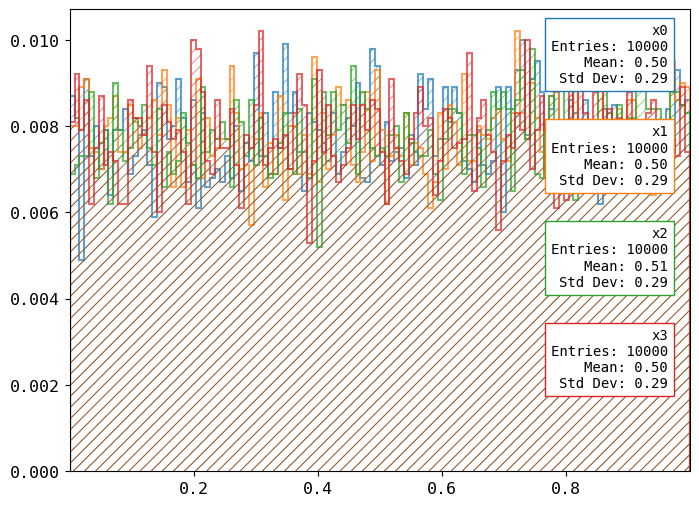

In [5]:
tf.keras.backend.set_floatx('float64')
integrate = build_iflow(camel, 4)
plot_proposal(integrate)

true
true
5000.000001193026
Epoch:   0 Loss = 4.173961e+00 Integral = 9.489237e-01 +/- 3.702771e-02 Total uncertainty = 3.702771e-02
5067.5847812577485
5127.3038770578041
5196.8650744407933
5295.8498613976781
5379.7797782454427
5490.961219522047
5574.1431937853777
5722.5172850991139
5848.5356515341919
6016.08156561147
Epoch:  10 Loss = 3.681278e+00 Integral = 9.893064e-01 +/- 3.501945e-02 Total uncertainty = 1.059243e-02
6234.95534237791
6414.60542086927
6546.9752431214965
6860.2660053489617
7050.5025415708633
7407.1355384951939
7740.701560738381
7999.065040107027
8611.14108815663
8708.9340901089017
Epoch:  20 Loss = 2.667448e+00 Integral = 9.912364e-01 +/- 2.825469e-02 Total uncertainty = 7.011325e-03
9355.9044178918957
9861.2698610853877
10379.825909701503
11258.167642835244
10920.888335391162
11768.078726436979
12261.063666459208
13277.801188372512
12651.888488591781
12980.672768031334
Epoch:  30 Loss = 2.457476e+00 Integral = 9.493959e-01 +/- 2.628501e-02 Total uncertainty = 5.3636

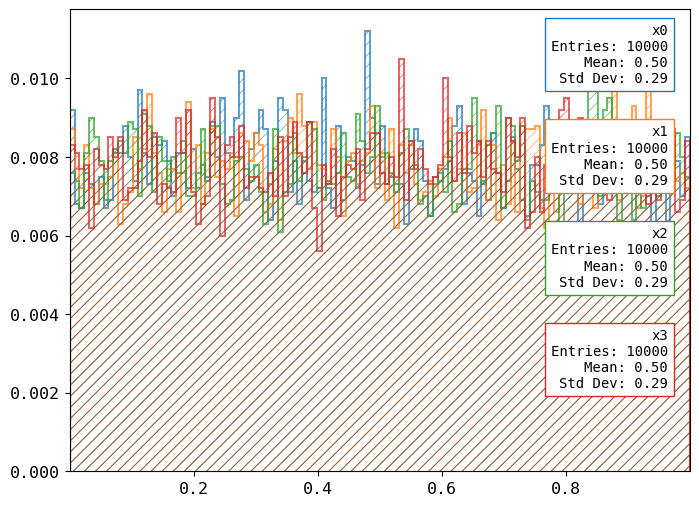

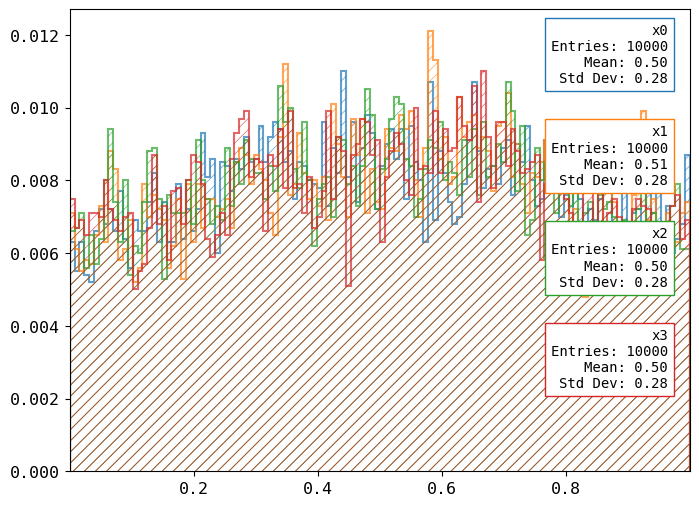

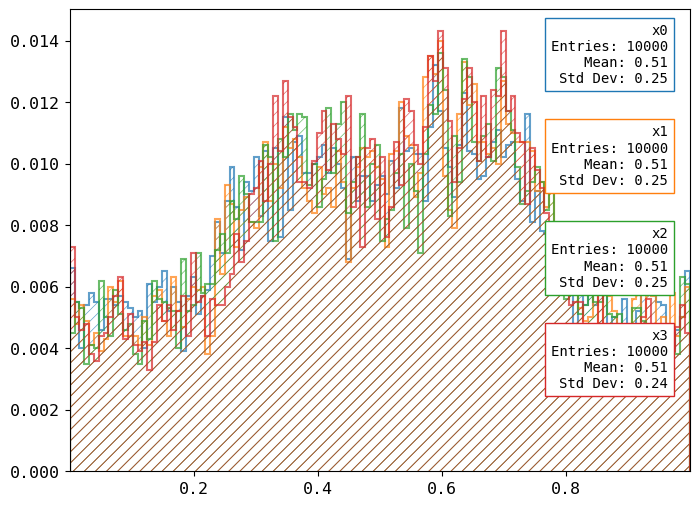

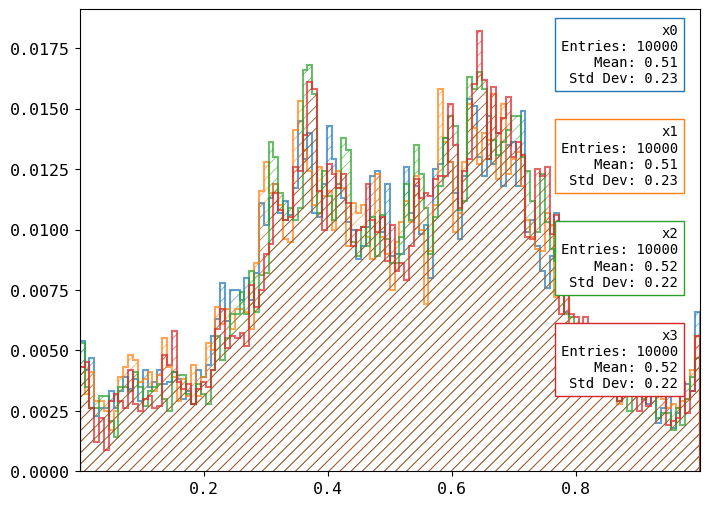

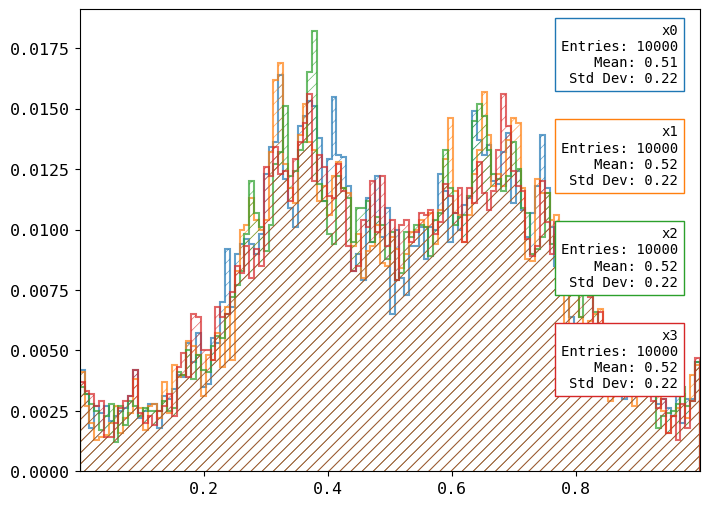

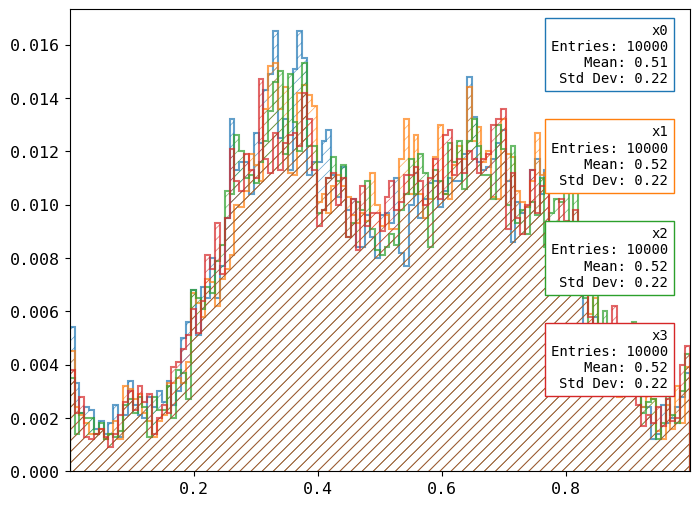

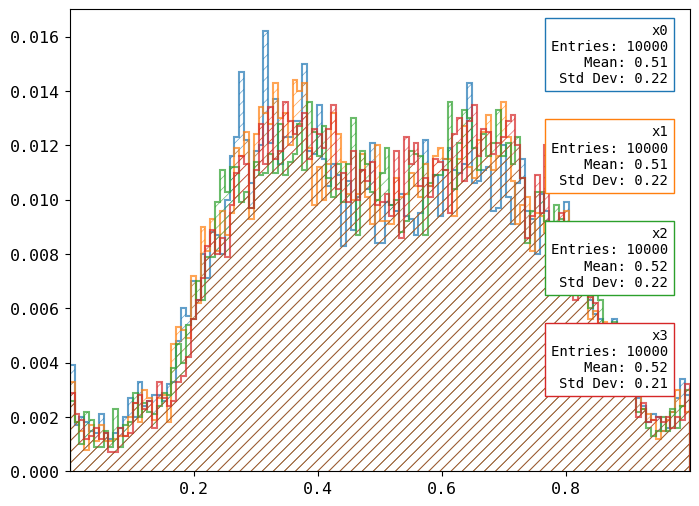

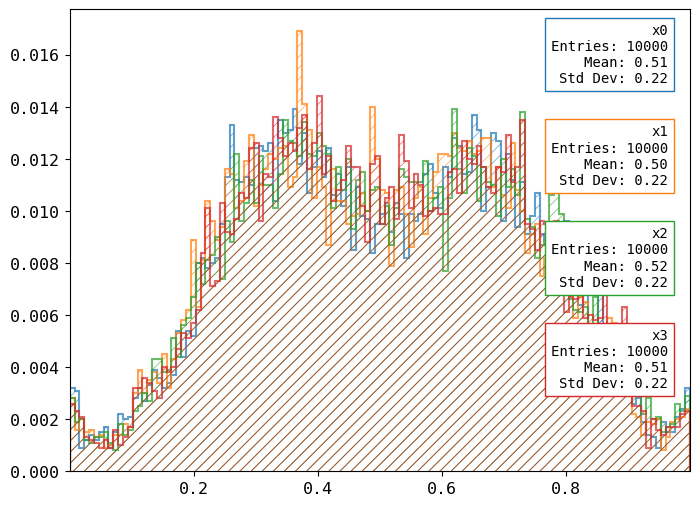

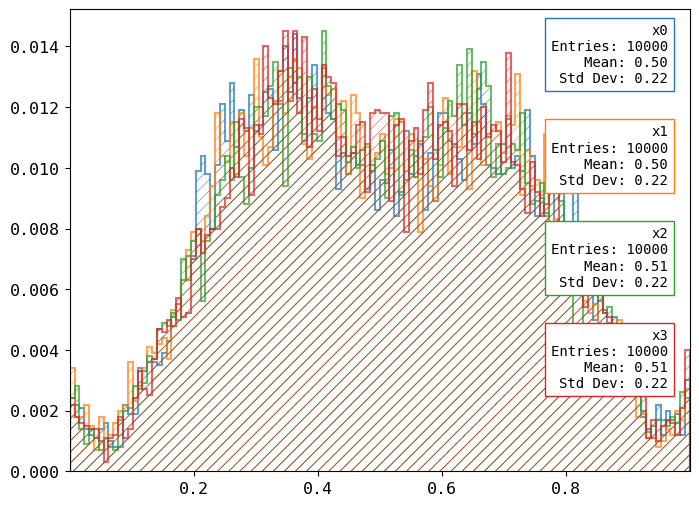

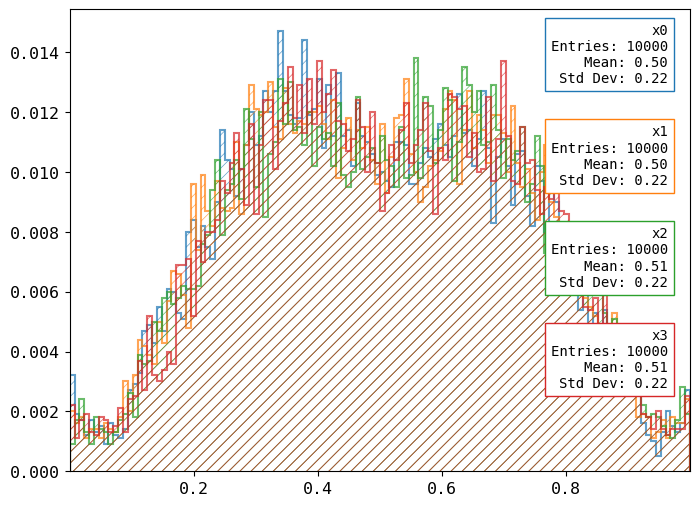

In [41]:
mean_t, err_t = train_iflow(integrate, 5000, 100, plot_proposal)
#plot_proposal(integrate)

Epoch:   0 Loss = 5.228194e-02 Integral = 9.589101e-01 +/- 3.465089e-03 Total uncertainty = 3.465089e-03
Epoch:  10 Loss = 4.685571e-02 Integral = 9.648136e-01 +/- 3.349347e-03 Total uncertainty = 1.031757e-03
Epoch:  20 Loss = 5.444375e-02 Integral = 9.610312e-01 +/- 3.558474e-03 Total uncertainty = 7.551844e-04
Epoch:  30 Loss = 4.819644e-02 Integral = 9.612088e-01 +/- 3.382028e-03 Total uncertainty = 6.248424e-04
Epoch:  40 Loss = 4.962590e-02 Integral = 9.615884e-01 +/- 3.390344e-03 Total uncertainty = 5.419774e-04
Epoch:  50 Loss = 5.228081e-02 Integral = 9.605653e-01 +/- 3.462373e-03 Total uncertainty = 4.846222e-04
Epoch:  60 Loss = 5.099224e-02 Integral = 9.701326e-01 +/- 3.477579e-03 Total uncertainty = 4.434241e-04
Epoch:  70 Loss = 4.762152e-02 Integral = 9.640647e-01 +/- 3.351479e-03 Total uncertainty = 4.117377e-04
Epoch:  80 Loss = 4.816343e-02 Integral = 9.659295e-01 +/- 3.346275e-03 Total uncertainty = 3.843484e-04
Epoch:  90 Loss = 4.867094e-02 Integral = 9.581306e-01 

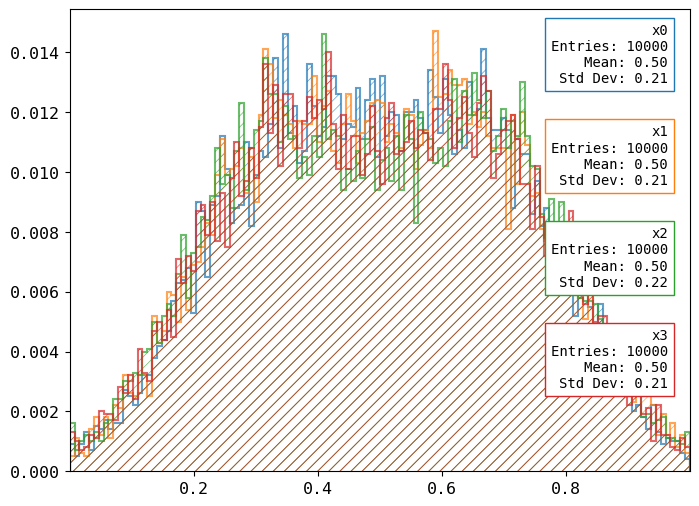

In [32]:
mean_t, err_t = train_iflow(integrate, 5000, 1000)
plot_proposal(integrate)